# CapsuleNetworks utilizando Tensorflow - MNIST

O objetivo desse notebook é implementar uma Capsule Network, detalhando suas camadas, e avaliando seu desempenho no mnist dataset. Será utilizado o framework TensorFlow, na versão 2.

O código desse notebook teve base na explicação do professor Aurélien Géron, por meio do vídeo - https://www.youtube.com/watch?v=2Kawrd5szHE e dos códigos disponíveis em https://github.com/ageron/handson-ml. 

Para começar, vamos importar as bibliotecas necessárias:

In [132]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

Para salvar os códigos/checkpoints do modelo:

In [133]:
if not os.path.exists("plots"):
    os.makedirs("plots")
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

Carregando o dataset MNIST e formatando os dados. Aqui escolhemos baches de 32.

In [134]:
model = None

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # normalização dos dados

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train.astype(np.float32))).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test.astype(np.float32))).batch(32)

print("Shape dados treinamento:", x_train.shape, y_train.shape)
print("Shape dados teste:", x_test.shape, y_test.shape)

# tamanho elementos por batch
print("Quantidade batchs treinamento:", x_train.shape[0] // 32
                          , "Quantidade batchs teste:", x_test.shape[0] // 32)

Shape dados treinamento: (60000, 28, 28) (60000,)
Shape dados teste: (10000, 28, 28) (10000,)
Quantidade batchs treinamento: 1875 Quantidade batchs teste: 312


Implementando as funções necessárias:

- Squash: Função de ativação que normaliza os valores dos vetores entre 0 e 1:

    $\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$


In [135]:
def squash(s, axis=-1, epsilon=1e-7):
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
    safe_norm = tf.sqrt(squared_norm + epsilon)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = s / safe_norm
    return squash_factor * unit_vector

- Safe Norm: Função para calcular a norma de forma a lidar com o caso de vetores 0 (oque poderia resultar em resultados NaN), colocando um epslon ao final.

In [136]:
def safe_norm(x, axis=-1, epsilon=1e-7, keepdims=False):
    squared_norm = tf.reduce_sum(tf.square(x), axis=axis, keepdims=keepdims)
    return tf.sqrt(squared_norm + epsilon)

Trabalharemos com essa arquitetura de rede:
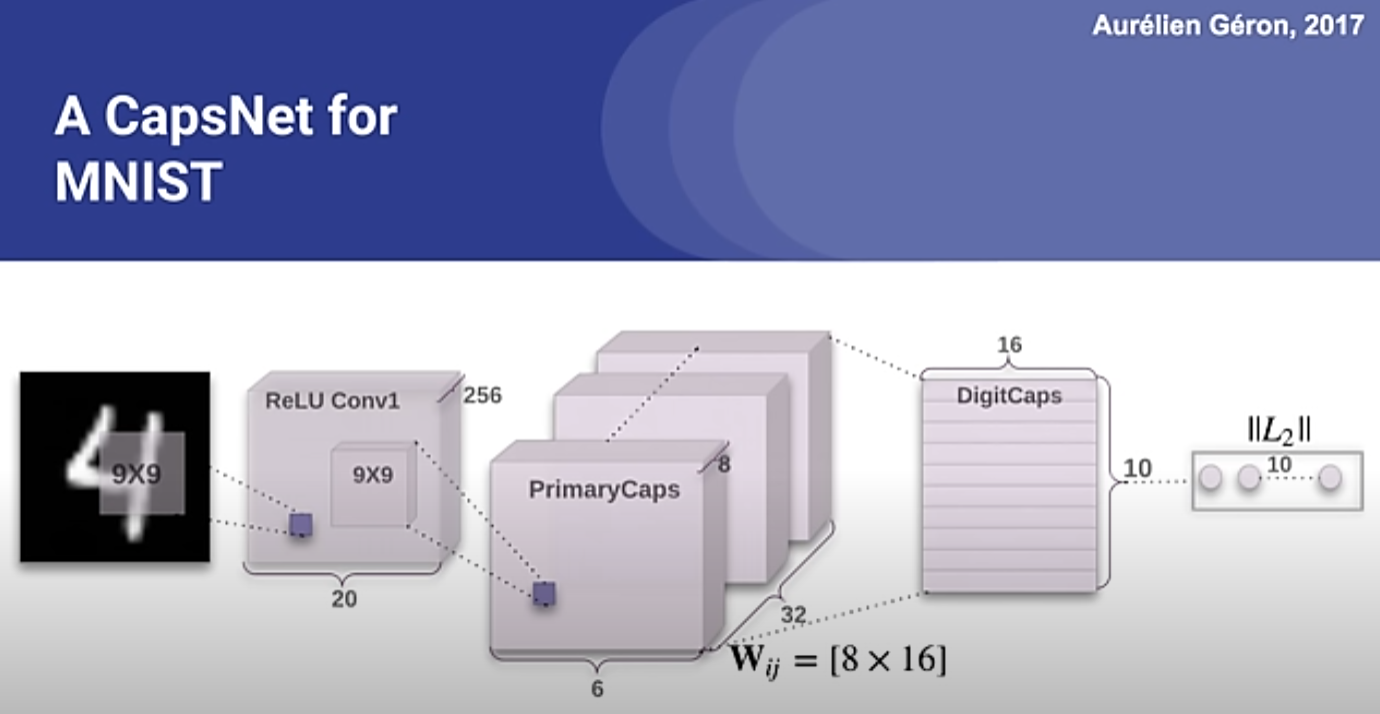

Definindo parametros da Capsnet:

In [137]:
caps1_n_maps = 32 # número de mapas de convolução
caps1_n_caps = caps1_n_maps * 6 * 6 # número de cápsulas na primeira camada
caps1_n_dims = 8 # número de dimensões por cápsula na primeira camada
caps2_n_caps = 10 # número de cápsulas na segunda camada
caps2_n_dims = 16 # número de dimensões por cápsula na segunda camada

Iniciando matriz de pesos, utilizamos a função do tensorflow para nos dar um vetor com uma distribuição normal. Usamos tf.variable para que o tensorflow consiga alterar seu valor durante o treinamento.

In [138]:
init_sigma = 0.1
W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32)
W = tf.Variable(W_init, name="W")
print("Shape W:", W.shape)

Shape W: (1, 1152, 10, 16, 8)


Agora, vamos a configuração do Keras para construir nossa CapsNet. 

Definindo pontos de entrada X e Y. É comum que haja no shape pontos com None como valor, pois estas são dimensões dinamicas, sendo alteradas durante execução. 

In [139]:
X_input = tf.keras.Input(shape=(28, 28), name='X_input')
y_input = tf.keras.Input(shape=(), name='y_input', dtype=tf.float32)

X = tf.keras.layers.Reshape((28, 28, 1))(X_input)

print("Shape X:", X.shape)
print("Shape y_input:", y_input.shape)

Shape X: (None, 28, 28, 1)
Shape y_input: (None,)


Construindo a camada primária, utilizando camadas convolucionais. O objetivo dessa camada é preparar a entrada para virar cápsulas. Em conv1 definimos uma camada de convolução que recebe a entrada X e utiliza da função de ativação ReLU. Já conv2, recebe conv1, utilizando a ativação ReLU também, e reduzindo a resolução espacial. Em caps1_raw, remodulamos o resultado para o formato N cápsulas, D dimensões por cápsula (1152 x 8). E ao output passamos a entrada pela função squash, para ser normalizada.

In [140]:
conv1 = tf.keras.layers.Conv2D(name="conv1", filters=256, kernel_size=9, strides=1, padding="valid", activation="relu")(X)
print("Shape conv1:", conv1.shape)
conv2 = tf.keras.layers.Conv2D(name="conv2", filters=caps1_n_maps * caps1_n_dims, kernel_size=9, strides=2, padding="valid", activation="relu")(conv1)
print("Shape conv2:", conv2.shape)
caps1_raw = tf.keras.layers.Reshape(target_shape=(caps1_n_caps, caps1_n_dims), name="caps1_raw")(conv2)
print("Shape caps1_raw:", caps1_raw.shape)
caps1_output = tf.keras.layers.Lambda(squash, name="caps1_squashed")(caps1_raw)
print("Shape caps1_output:", caps1_output.shape)


Shape conv1: (None, 20, 20, 256)
Shape conv2: (None, 6, 6, 256)
Shape caps1_raw: (None, 1152, 8)
Shape caps1_output: (None, 1152, 8)


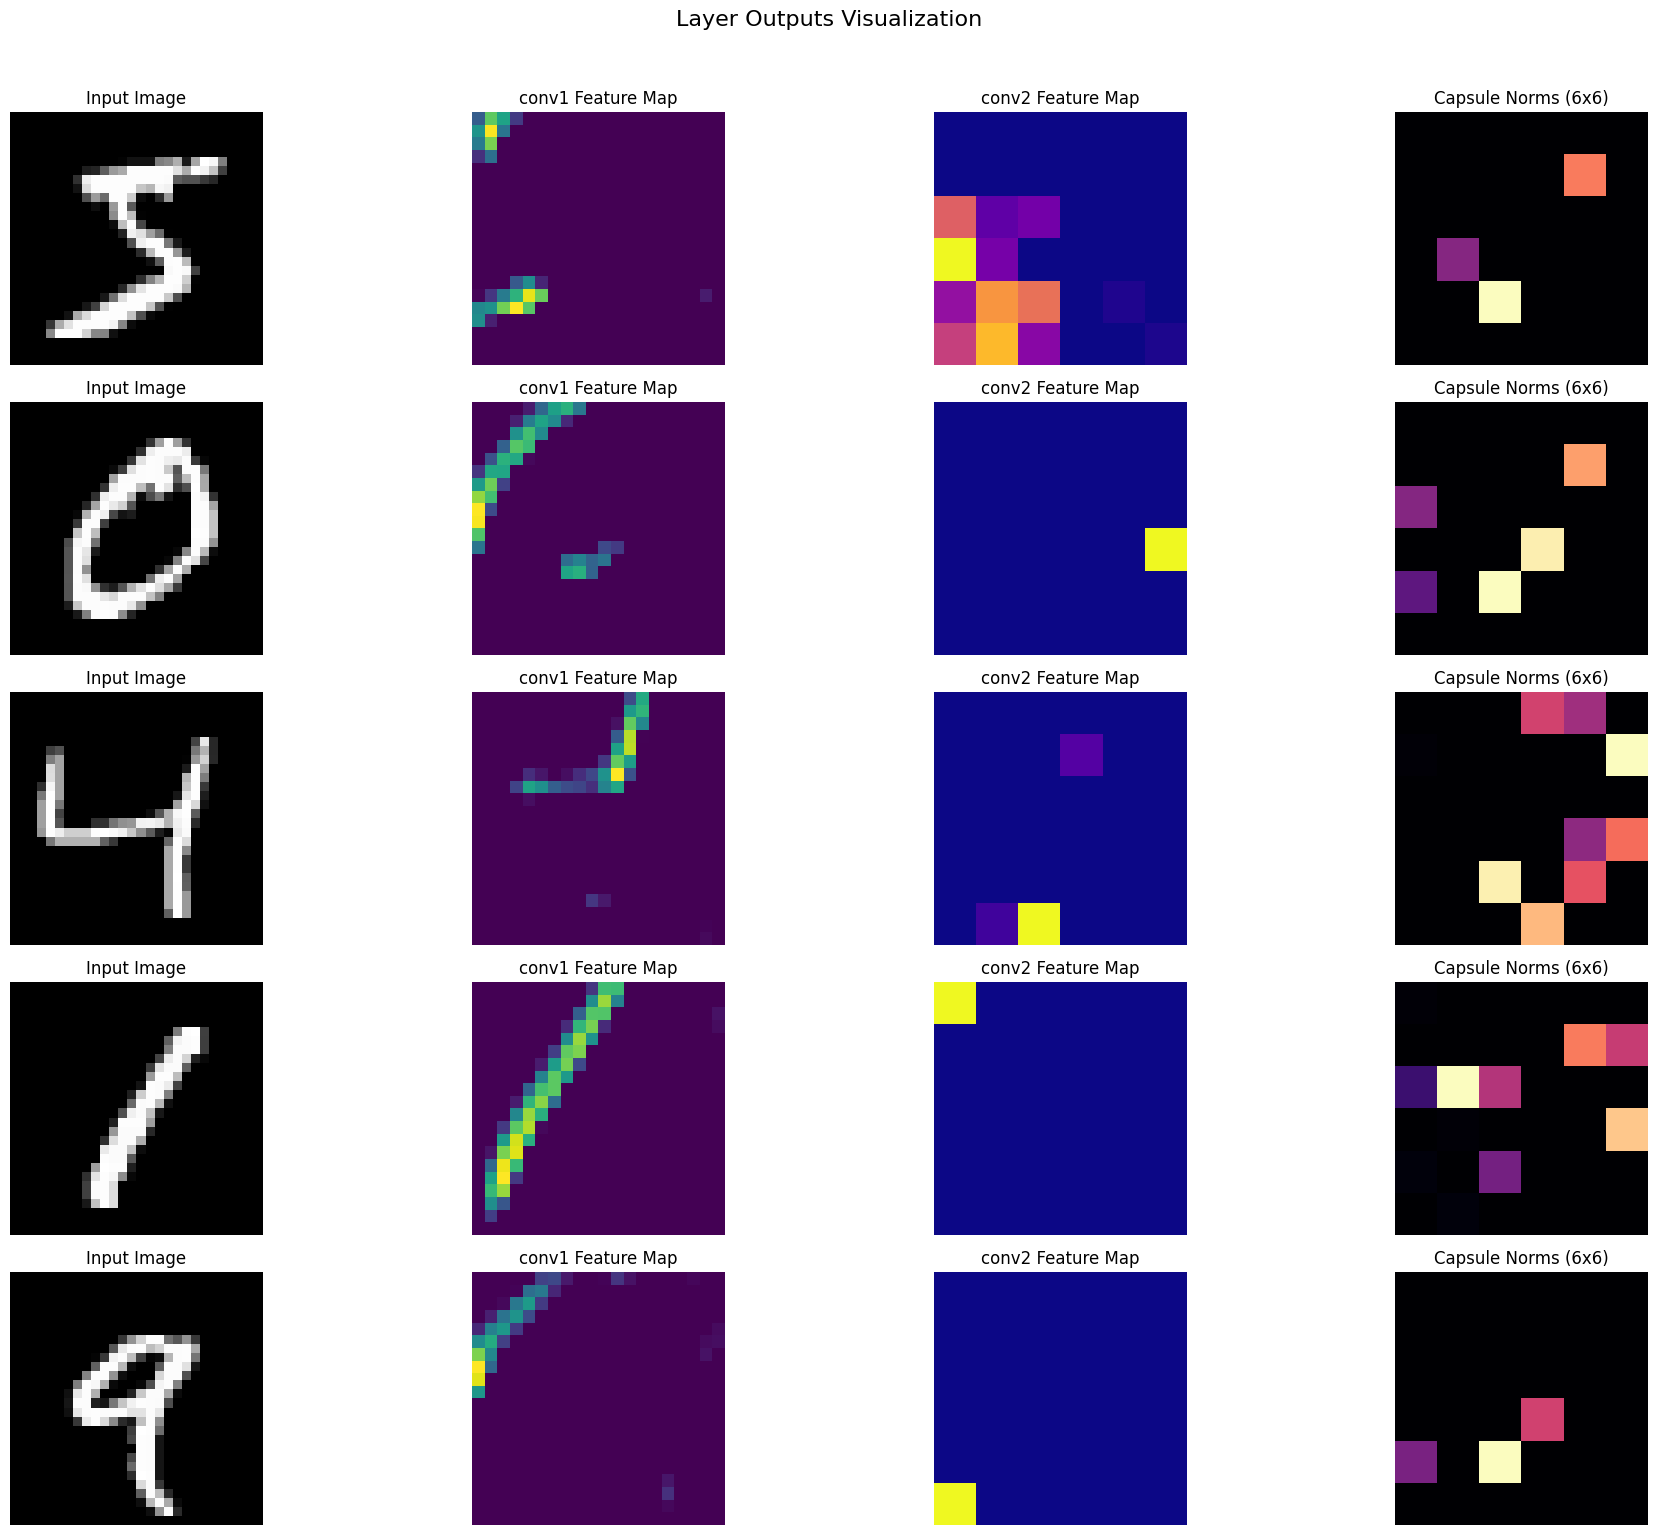

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt
from tensorflow.keras import Model

sample_images = x_train[:5]

model_conv1 = None
model_conv2 = None
model_caps1_raw = None
model_caps1_output = None

if model:
    sample_labels = y_train[:5]
    resultados = model.predict([sample_images, sample_labels], verbose=0)
    conv1_out = resultados[8]
    conv2_out = resultados[9]
    caps1_raw_out = resultados[10]
    caps1_output_out = resultados[11]
else:
    model_conv1 = Model(inputs=X_input, outputs=conv1)
    model_conv2 = Model(inputs=X_input, outputs=conv2)
    model_caps1_raw = Model(inputs=X_input, outputs=caps1_raw)
    model_caps1_output = Model(inputs=X_input, outputs=caps1_output)

    conv1_out = model_conv1.predict(sample_images)
    conv2_out = model_conv2.predict(sample_images)
    caps1_raw_out = model_caps1_raw.predict(sample_images)
    caps1_output_out = model_caps1_output.predict(sample_images)

fig, axes = plt.subplots(5, 4, figsize=(20, 15))
plt.suptitle('Layer Outputs Visualization', y=1.02, fontsize=16)

for i in range(5):
    axes[i, 0].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(conv1_out[i, :, :, 0], cmap='viridis')
    axes[i, 1].set_title('conv1 Feature Map')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(conv2_out[i, :, :, 0], cmap='plasma')
    axes[i, 2].set_title('conv2 Feature Map')
    axes[i, 2].axis('off')
    
    # primeiras 36 cápsulas da primeira camada
    caps_norms = np.linalg.norm(caps1_output_out[i][:36], axis=1).reshape(6, 6)
    axes[i, 3].imshow(caps_norms, cmap='magma')
    axes[i, 3].set_title('Capsule Norms (6x6)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))


Para o layer das capsulas de digitos, precisaremos de um algoritmo de roteamento dinâmico -- routing-by-agreement. Em redes neurais feed-forward, há a dinÇamica de definir pesos entre dois neurônios quaisquer, porém, após o treinamento esses pesos são fixos, independentes do input. No caso das Capsnets, há coeficientes adicionais aplicados nesses pesos, e os valores deles dependem do dado de entrada -- [Artigo Referência](http://hdc.cs.arizona.edu/~mwli/understanding-capsule-network/writing/).


![dynamic-routing-explained.png](./img_notebooks/dynamic-routing-explained.png)

O algoritmo routing_by_agreement irá atualizar os coeficientes de roteamento. É calculado as predições iniciais para as cápsulas superiores através de uma multiplicação matricial  entre os pesos e as cápsulas expandidas.

Esses pesos de roteamento são iniciados como zero, e passam por uma função softmax, sendo estas predições ponderadas, somadas e comprimidas utilizando a função squash.

Na segunda rodada, o algoritmo mede a concordância (agreement) entre as predições iniciais e a saída, atualizando os pesos de rotamento para priorizar cápsulas com maior concordância.

In [142]:
def routing_by_agreement(caps1_output):
    batch_size = tf.shape(caps1_output)[0]
    W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1])
    
    caps1_output_expanded = tf.expand_dims(caps1_output, -1)
    caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2)
    caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1])
    
    caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled)
    raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=tf.float32)

    # Round 1
    routing_weights = tf.nn.softmax(raw_weights, axis=2)
    weighted_predictions = routing_weights * caps2_predicted
    weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True)
    caps2_output_round_1 = squash(weighted_sum, axis=-2) 

    # Round 2
    agreement = tf.matmul(caps2_predicted, caps2_output_round_1, transpose_a=True)
    raw_weights_round_2 = raw_weights + agreement
    routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, axis=2)
    weighted_predictions_round_2 = routing_weights_round_2 * caps2_predicted
    weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keepdims=True)
    caps2_output_5d = squash(weighted_sum_round_2, axis=-2)
    
    return tf.squeeze(caps2_output_5d, axis=-1)


O caps2_output irá trazer informações de magnitude (probabilidade) e orientação. O vetor da probabilidade está no índice com 10 elementos (para cada classe), enquanto as informações de orientação está no vetor 16D, e contem informações como orientação, espessura, etc, sendo esses parametros encontrados durante treinamento.

In [143]:
caps2_output = tf.keras.layers.Lambda(routing_by_agreement, name="digit_caps")(caps1_output)
print("Shape caps2_output:", caps2_output.shape)
print(caps2_output)

Shape caps2_output: (None, 1, 10, 16)
<KerasTensor shape=(None, 1, 10, 16), dtype=float32, sparse=False, name=keras_tensor_310>


Orientation of predicted digit 5: [ 0.27427527 -0.23937427 -0.24054953 -0.250937   -0.2646533  -0.25012156
 -0.20292841 -0.2535549   0.22023255  0.24795264  0.03006301  0.25452262
  0.22442512 -0.2483443   0.26601073  0.07537672]
Orientation of predicted digit 0: [-0.26479885 -0.21692842  0.27392575 -0.25210875 -0.23368475  0.25579733
  0.24552129 -0.19662642 -0.20871845 -0.2552052   0.27523026  0.2002315
 -0.2551388  -0.21268174 -0.26271087  0.1982055 ]
Orientation of predicted digit 4: [ 0.212845    0.22345698 -0.28554833  0.19966984  0.24303885 -0.26018187
  0.27851617  0.06090841  0.23826481  0.2591462  -0.31486747 -0.2486723
  0.26970273 -0.22915326  0.22490019  0.17387243]
Orientation of predicted digit 1: [ 0.23410322  0.19398823 -0.26326987 -0.10231832  0.19078976  0.21702978
 -0.19576958  0.17560516  0.2855835   0.1930085   0.3126298   0.26161063
  0.27085707 -0.21858504 -0.24223767 -0.2497659 ]
Orientation of predicted digit 9: [ 0.17711931 -0.2085852   0.24503978  0.1925316 

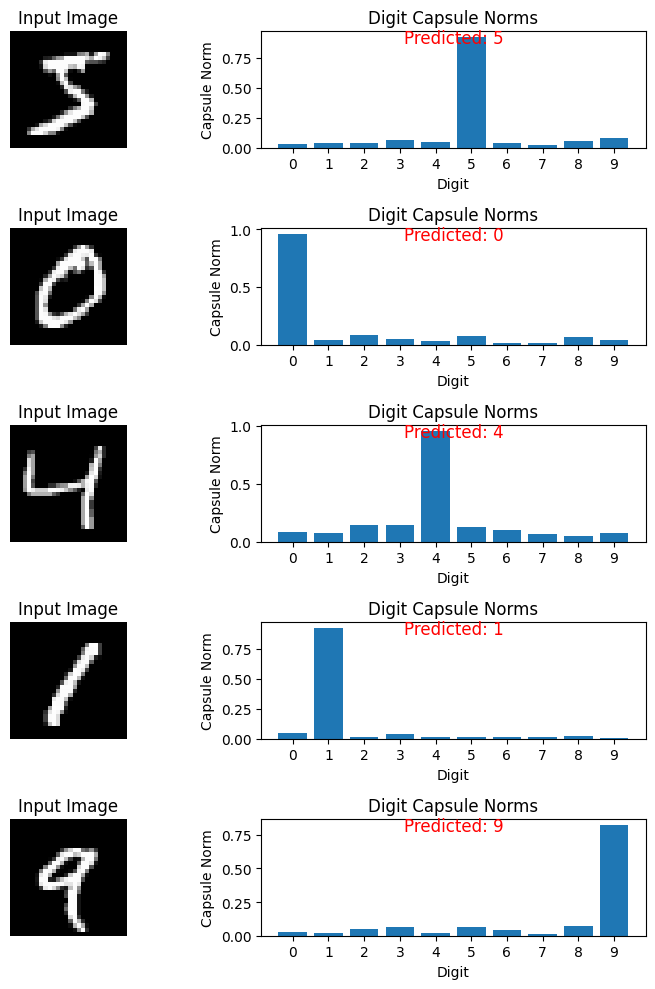

In [157]:
caps2_out = None
sample_images = x_train[:5]

if model:
    sample_labels = y_train[:5]

    predictions = model.predict([sample_images, sample_labels], verbose=0)
    caps2_out = predictions[7]


else:
    model_caps2_output = tf.keras.Model(inputs=X_input, outputs=caps2_output)
    caps2_out = model_caps2_output.predict(sample_images)

caps2_out = np.squeeze(caps2_out, axis=1)

caps2_norms = np.linalg.norm(caps2_out, axis=-1) 

fig, axes = plt.subplots(5, 2, figsize=(8, 2 * 5))
for i in range(5):
    axes[i, 0].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].bar(np.arange(10), caps2_norms[i])
    axes[i, 1].set_title('Digit Capsule Norms')
    axes[i, 1].set_xlabel('Digit')
    axes[i, 1].set_ylabel('Capsule Norm')
    axes[i, 1].set_xticks(np.arange(10))

    #winning votes
    winning_digit = np.argmax(caps2_norms[i])
    axes[i, 1].text(0.5, 0.9, f'Predicted: {winning_digit}', transform=axes[i, 1].transAxes,
                    horizontalalignment='center', fontsize=12, color='red')

    # orientation of the capsule
    orientation = caps2_out[i, winning_digit]
    print(f"Orientation of predicted digit {winning_digit}: {orientation}")
plt.tight_layout()
plt.show()

Estimando a probabilidade das classes:

In [145]:
y_proba = tf.keras.layers.Lambda(lambda x: safe_norm(x, axis=-1), name="y_proba")(caps2_output)
y_proba_squeezed = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="y_proba_squeezed")(y_proba)
y_predict = tf.keras.layers.Lambda(lambda x: tf.cast(tf.argmax(x, axis=1), dtype=tf.float32), name="y_predict")(y_proba_squeezed)
print("Shape y_predict:", y_predict.shape)


Shape y_predict: (None,)


Para calcular a margem de perda, utilizaremos a equação (fornecida pelo [artigo](https://arxiv.org/abs/1710.09829)):

$$
L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2
$$

Onde:
- T_k é igual a 1 se o digito da classe k é presente, ou 0 caso contrário

Em caps2_output_norm, usamos a função de norma no vetor 16D.

present_error = $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$

absent_error = $\max(0, \|\mathbf{v}_k\| - m^{-})^2$

In [146]:
m_plus = 0.9
m_minus = 0.1
lambda_loss = 0.5

T = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x, dtype=tf.int32), depth=caps2_n_caps), name="T_one_hot")(y_input)
caps2_output_norm = tf.keras.layers.Lambda(lambda x: tf.squeeze(safe_norm(x, axis=-1), axis=[1]), name="caps2_output_norm")(caps2_output)

present_error = tf.keras.layers.Lambda(lambda x: tf.square(tf.maximum(0., m_plus - x)), name="present_error")(caps2_output_norm)
absent_error = tf.keras.layers.Lambda(lambda x: tf.square(tf.maximum(0., x - m_minus)), name="absent_error")(caps2_output_norm)

L_present = tf.keras.layers.Multiply(name="L_present")([T, present_error])
L_absent_term = tf.keras.layers.Lambda(lambda x: lambda_loss * (1.0 - x), name="L_absent_term")(T)
L_absent = tf.keras.layers.Multiply(name="L_absent")([L_absent_term, absent_error])
L_components = tf.keras.layers.Add(name="L_components")([L_present, L_absent])

margin_loss = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(tf.reduce_sum(x, axis=1)), name="margin_loss")(L_components)


Agora, vamos ao Decoder. Essa parte da CapsNet é responsável por reconstruir as imagens de entrada com base no output das camadas de capsula. Assim, a camada de capsulas irá preservar informações que permitam a reconstrução da imagem do dígito. Essa parte ajuda a regularizar o modelo, ajudando reduzir o risco de overfitting e generalizar para novos digitos.

- reconstruction_mask cria mascara para selecionar apenas capsulas ativas correspondentes ao digito correto.

- decoder - Só é possivel por conta das informações salvas no vetor 16D: 
    - Dense(512) + Dense(1024) = expande a capsula 16D
    - Dense(784) = 28x28 image

- perda: Verifica o quão acurada foi a reconstrução do dígito.

In [147]:
reconstruction_mask = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x, dtype=tf.int32), depth=caps2_n_caps), name="reconstruction_mask")(y_input)
reconstruction_mask_reshaped = tf.keras.layers.Reshape((1, caps2_n_caps, 1))(reconstruction_mask)

caps2_output_masked = tf.keras.layers.Multiply()([caps2_output, reconstruction_mask_reshaped])
decoder_input = tf.keras.layers.Flatten()(caps2_output_masked)

decoder_hidden1 = tf.keras.layers.Dense(512, activation="relu")(decoder_input)
decoder_hidden2 = tf.keras.layers.Dense(1024, activation="relu")(decoder_hidden1)
decoder_output = tf.keras.layers.Dense(784, activation="sigmoid",name="decoder_output")(decoder_hidden2)

X_flat = tf.keras.layers.Flatten()(X)
squared_difference = tf.keras.layers.Lambda(lambda x: tf.square(x[0] - x[1]))([decoder_output, X_flat])
reconstruction_loss = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x), name="reconstruction_loss")(squared_difference)

Loss: 0.015864188


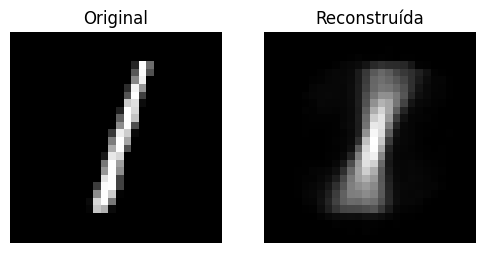

In [156]:
from tensorflow.keras import Model

example_idx = 2
example_image = x_test[example_idx]
example_label = y_test[example_idx]

input_image = np.expand_dims(example_image, axis=0)
input_label = np.expand_dims(example_label, axis=0)

decoder_model = None
if model:
    decoder_model = model
    reconstructed = decoder_model.predict([input_image, input_label], verbose=0)
    reconstructed = (reconstructed[4], reconstructed[6])  # unpacking the tuple
else:
    decoder_model = Model(inputs=[X_input, y_input], outputs=(decoder_output, reconstruction_loss))
    reconstructed = decoder_model.predict([input_image, input_label])

print("Loss:", reconstructed[1])
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(example_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstruída")
plt.imshow(reconstructed[0].reshape(28,28), cmap='gray')
plt.axis('off')
plt.show()

Perda total da rede:

In [149]:
alpha = 0.0005
scaled_recon_loss = tf.keras.layers.Lambda(lambda x: alpha * x, name="scaled_recon_loss")(reconstruction_loss)
total_loss = tf.keras.layers.Lambda(lambda x: x[0] + x[1], name="total_loss")([margin_loss, scaled_recon_loss])


Para mensurar acurácia do modelo (contando acertos):

In [150]:
correct = tf.keras.layers.Lambda(lambda x: tf.cast(tf.equal(x[0], x[1]), tf.float32), name="correct")([y_input, y_predict])
accuracy = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x), name="accuracy")(correct)

Utilizaremos o otimizador Adam do tensorflow. Além disso, salvaremos o progresso de treino do treino. 

In [151]:
model = tf.keras.Model(
    inputs=[X_input, y_input],
    outputs=[total_loss, accuracy, y_predict, y_proba_squeezed, decoder_output, margin_loss, reconstruction_loss, caps2_output, conv1, conv2, caps1_raw, caps1_output],
)

@tf.function
def val_step(images, labels):
    loss, acc, _,_,_,_,_,_,_,_,_,_ = model([images, labels], training=False)
    return loss, acc

In [152]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epoch_counter = tf.Variable(0, dtype=tf.int32, name='epoch_counter')
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model,  W=W, epoch_counter=epoch_counter)
tmp_dir = os.path.join(os.getcwd(), "checkpoints", "tmp")
print(f"Temporary directory for checkpoints: {tmp_dir}")

if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
manager = tf.train.CheckpointManager(ckpt, tmp_dir , max_to_keep=1)

n_epochs = 3
best_val_loss = np.inf

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_acc_metric = tf.keras.metrics.Mean(name='train_acc')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
val_acc_metric = tf.keras.metrics.Mean(name='val_acc')

latest_checkpoint = manager.latest_checkpoint
if latest_checkpoint:
    print(f"Restoring from checkpoint: {latest_checkpoint}")
    status = ckpt.restore(latest_checkpoint)
    status.expect_partial()
    status.assert_existing_objects_matched()
    val_loss_metric.reset_state()
    val_acc_metric.reset_state()
    for images, labels in test_ds:
        val_loss, val_acc = val_step(images, labels)
        val_loss_metric.update_state(val_loss)
        val_acc_metric.update_state(val_acc)
    
    print(f"Restored Model Validation - Loss: {val_loss_metric.result():.4f} - Acc: {val_acc_metric.result():.4f}")


Temporary directory for checkpoints: c:\Users\mangl\Documents\Mestrado UFSC\Inteligencia Artificial\Inteligencia-Artificial-Conexionista\CapsNet\checkpoints\tmp
Restoring from checkpoint: c:\Users\mangl\Documents\Mestrado UFSC\Inteligencia Artificial\Inteligencia-Artificial-Conexionista\CapsNet\checkpoints\tmp\ckpt-1
Restored Model Validation - Loss: 0.0123 - Acc: 0.9896


Funções padrão para treinamento, utiliza backpropagation, computando os gradientes da perda com respeito as variaveis treinaveis.

In [153]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        loss, acc,_,_,_,_,_,_,_,_,_,_  = model([images, labels], training=True)
    trainable_vars = model.trainable_variables + [W]
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    return loss, acc


Parte do treinamento:

In [154]:
initial_epoch = int(epoch_counter.numpy()) if manager.latest_checkpoint else 0
print(f"Initial epoch: {manager.latest_checkpoint}")
print(f"Starting training from epoch {initial_epoch}")
for epoch in range(initial_epoch, n_epochs):
    epoch_counter.assign(epoch + 1)
    print(f"\nEpoch {epoch + 1}/{n_epochs}")
    train_loss_metric.reset_state()
    train_acc_metric.reset_state()
    val_loss_metric.reset_state()
    val_acc_metric.reset_state()


    #
    # Training
    for i, (images, labels) in enumerate(train_ds):
        loss, acc = train_step(images, labels)
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(acc)
        print(f"\r  Training: Batch {i+1}/{len(train_ds)} - Loss: {train_loss_metric.result():.4f} - Acc: {train_acc_metric.result():.4f}", end="")

    # Validation
    for images, labels in test_ds:
        loss, acc = val_step(images, labels)
        val_loss_metric.update_state(loss)
        val_acc_metric.update_state(acc)

    print(f"\n  Validation - Loss: {val_loss_metric.result():.4f} - Acc: {val_acc_metric.result():.4f}")

    if val_loss_metric.result() < best_val_loss:
        best_val_loss = val_loss_metric.result()
        save_path = manager.save()
        print(f"  Best model saved to {save_path}")

print("\nTraining complete.")

Initial epoch: c:\Users\mangl\Documents\Mestrado UFSC\Inteligencia Artificial\Inteligencia-Artificial-Conexionista\CapsNet\checkpoints\tmp\ckpt-1
Starting training from epoch 1

Epoch 2/3
  Training: Batch 1875/1875 - Loss: 0.0103 - Acc: 0.9917
  Validation - Loss: 0.0093 - Acc: 0.9924
  Best model saved to c:\Users\mangl\Documents\Mestrado UFSC\Inteligencia Artificial\Inteligencia-Artificial-Conexionista\CapsNet\checkpoints\tmp\ckpt-2

Epoch 3/3
  Training: Batch 1875/1875 - Loss: 0.0066 - Acc: 0.9951
  Validation - Loss: 0.0094 - Acc: 0.9925

Training complete.


Fazendo a prediction de números:

Predicted labels: [7 2 1 0 4]


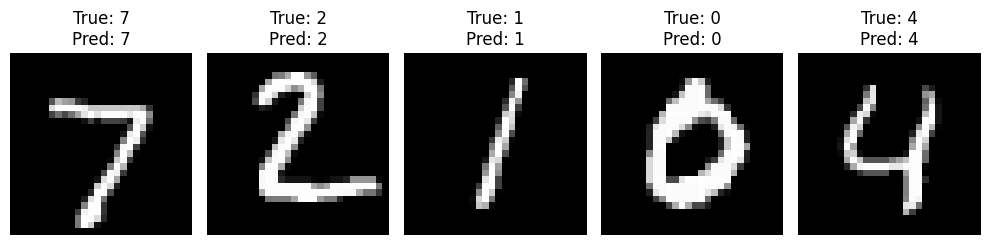

In [159]:
n_samples = 5    

sample_images_predict = x_test[:n_samples]
sample_labels_predict = y_test[:n_samples]

predictions = model.predict([sample_images_predict, sample_labels_predict], verbose=0)
predictions = predictions[3]  
predicted_labels = np.argmax(predictions, axis=1)
print(f"Predicted labels: {predicted_labels}")

plt.figure(figsize=(n_samples * 2, 3))
for index, (image, label, pred) in enumerate(zip(sample_images_predict, sample_labels_predict, predicted_labels)):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {int(label)}\nPred: {pred}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("plots/predictions.png")
plt.show()
# Save the model architecture and weights